In [26]:
import numpy as np
import pandas as pd
from pandas.core.window import rolling

def calculate_shadow_ratio(bars):
    """计算上下影线因子(归一化)
    
    按研报要求，标准化蜡烛上影线为当日上影线/过去5日上影线均值。标准化蜡烛下影线同。
    """
    high = bars['high']
    low = bars['low']
    open_price = bars['open']
    close = bars['close']

    # 为避免除零错误，这里我们使用了一个技巧，即通过mask来排除可能除零的计算
    # 无法计算时，设置为0，表明无信号
    up_shadow_ratio = pd.Series(0, index=bars.index)
    down_shadow_ratio = pd.Series(0, index=bars.index)

    up_shadow = high - np.maximum(open_price, close)
    rolling_up_shadow = up_shadow.rolling(5).mean()
    mask = (rolling_up_shadow > 1e-8) & (~rolling_up_shadow.isna())
    up_shadow_ratio[mask] = up_shadow[mask] / rolling_up_shadow[mask]

    down_shadow = np.minimum(open_price, close) - low
    rolling_down_shadow = down_shadow.rolling(5).mean()
    mask = (rolling_down_shadow > 1e-8) & (~rolling_down_shadow.isna())
    down_shadow_ratio[mask] = down_shadow[mask] / rolling_down_shadow[mask]

    return up_shadow_ratio, down_shadow_ratio


def calculate_williams_r_ratio(bars):
    """
    计算变种威廉指标
    """
    high = bars['high']
    low = bars['low']
    close = bars['close']
    
    wr_up = high - close
    wr_down = close - low

    rolling_wr_up = wr_up.rolling(5).mean()
    rolling_wr_down = wr_down.rolling(5).mean()

    up_mask = rolling_wr_up > 1e-8
    down_mask = rolling_wr_down > 1e-8

    # 与蜡烛上下影线的默认值不同，0.5更能表明无信号的含义
    wr_up_ratio = pd.Series(0.5, index=bars.index)
    wr_down_ratio = pd.Series(0.5, index=bars.index)

    wr_up_ratio[up_mask] = wr_up[up_mask] / rolling_wr_up[up_mask]
    wr_down_ratio[down_mask] = wr_down[down_mask] / rolling_wr_down[down_mask]

    return wr_up_ratio, wr_down_ratio

start = datetime.date(2009,1,1 )
end = datetime.date(2020,4,30)
barss = load_bars(start, end, 10)

def calc_monthly(daily_factor, aggfunc, win=20):
    dates = barss.index.get_level_values('date').unique().sort_values()
    month_ends = dates.to_frame(name = "date").resample('BME').last().values

    dfs = []

    for date in month_ends:
        date_ts = pd.Timestamp(date.item())
        iend = dates.get_loc(date_ts)
        istart = max(0, iend - win + 1)
        start_ = pd.Timestamp(dates[istart])
        end_ = date_ts
        window_data = daily_factor.loc[start_: end_]

        df = (window_data.groupby(level="asset")
                        .agg(aggfunc)
                        .to_frame("factor")
        )
        df["date"] = date_ts
        dfs.append(df)

    df = pd.concat(dfs)
    return df.set_index(["date", df.index]).sort_index()

def calc_candle_up_std_factor(barss, win = 20):
    up_shadow = barss.groupby("asset", group_keys=False).apply(lambda x: calculate_shadow_ratio(x)[0]).sort_index()

    return calc_monthly(up_shadow, "std", win)

def calc_wr_down_factor(barss, win = 20):
    wr_down = barss.groupby("asset", group_keys=False).apply(lambda x: calculate_williams_r_ratio(x)[1]).sort_index()

    return calc_monthly(wr_down, "mean", win)

def calc_ubl_factor(barss, win = 20):
    from scipy.stats import zscore

    up_std = calc_candle_up_std_factor(barss, win)
    wr_down = calc_wr_down_factor(barss, win)

    # 截面zscore
    z_scored_up_std_factor = up_std.groupby("date").transform(zscore)
    z_scored_wr_down = wr_down.groupby("date").transform(zscore)

    return z_scored_up_std_factor + z_scored_wr_down

In [48]:
dates = pd.bdate_range('2019-01-01', '2019-01-31')
cols = ["open", "high", "low", "close"]
df1 = pd.DataFrame([(2, 3, 1, 2)] * len(dates), index=dates, columns=cols)
df1["asset"] = "A"

df2 = pd.DataFrame([(2, 3, 0, 0)] * len(dates), index=dates, columns=cols)
df2["asset"] = "B"

barss = pd.concat([df1, df2]).set_index("asset", append=True)
barss.index.set_names(["date", "asset"], inplace=True)
barss.sort_index(inplace=True)

# display(calc_candle_up_std_factor(barss, 20))
display(calc_wr_down_factor(barss, 20))

factor
date       asset        
2019-01-31 A       0.975
           B       0.500

In [49]:
arr = [1] * 20
arr[0] = 0.5
np.mean(arr)


np.float64(0.975)

## Alphatest

In [3]:
# 研报回测期
start = datetime.date(2009,1,1 )
end = datetime.date(2020,4,30)

def calc_upper_shadow_factor(bars: pd.DataFrame, win: int=20):
    """根据研报，UBL因子最终选择了上影线标准差作为成分。为了对比，这里我们也选标准差"""
    up, _ = calculate_shadow_ratio(bars)

    return up.rolling(win).std() * -1

# alphatest(50, start, end, calc_upper_shadow_factor, (20,))

In [2]:
def calc_ubl_factor(barss: pd.DataFrame, win: int = 20):
    """计算ubl因子
    
    根据研报，ubl因子为zscore(std(up_shadow_ratio)) + zscore(std(wr_down_ratio))
    """
    pass

In [4]:
import sys

sys.path.insert(0, "./docs/blog/posts/papers/ubl")

from monthly_factor_backtest import *

barss = load_bars(start, end, 50)
factor_data = (barss.groupby(level="asset")
                    .apply(lambda x: calc_upper_shadow_factor(x, 20))
                    .droplevel(level=0)
)

returns = monthly_factor_backtest(factor_data, barss)
returns

,Q1,Q2,Q3,Q4,Q5
2009-02-01,0.345573,0.230387,0.228000,0.124089,0.139869
2009-03-01,0.049935,0.009118,-0.026737,-0.035118,-0.007954
2009-04-01,0.110477,0.115158,0.117250,0.107950,0.205011
2009-05-01,0.031488,0.073551,0.092930,0.118229,0.061097
2009-06-01,0.047686,0.045705,0.372182,0.311275,0.042926
...,...,...,...,...,...
2019-11-01,0.025295,0.091982,0.060381,0.148900,0.076818
2019-12-01,-0.014981,-0.009306,-0.003421,-0.004252,0.012805
2020-01-01,0.200449,0.145341,0.126821,0.207154,0.101577
2020-02-01,-0.087275,-0.018490,-0.037929,-0.084410,-0.115677


In [5]:
calculate_group_statistics(returns)

,年化收益率,年化波动率,夏普比率,最大回撤,胜率,月均收益率,月收益率标准差
Q1,0.121581,0.343037,0.354427,-0.662513,0.522388,0.010132,0.099026
Q2,0.160135,0.328977,0.486766,-0.649800,0.507463,0.013345,0.094967
Q3,0.246906,0.406864,0.606853,-0.723604,0.552239,0.020576,0.117451
Q4,0.158411,0.356178,0.444753,-0.570105,0.537313,0.013201,0.102820
Q5,0.208155,0.315544,0.659670,-0.493057,0.574627,0.017346,0.091090


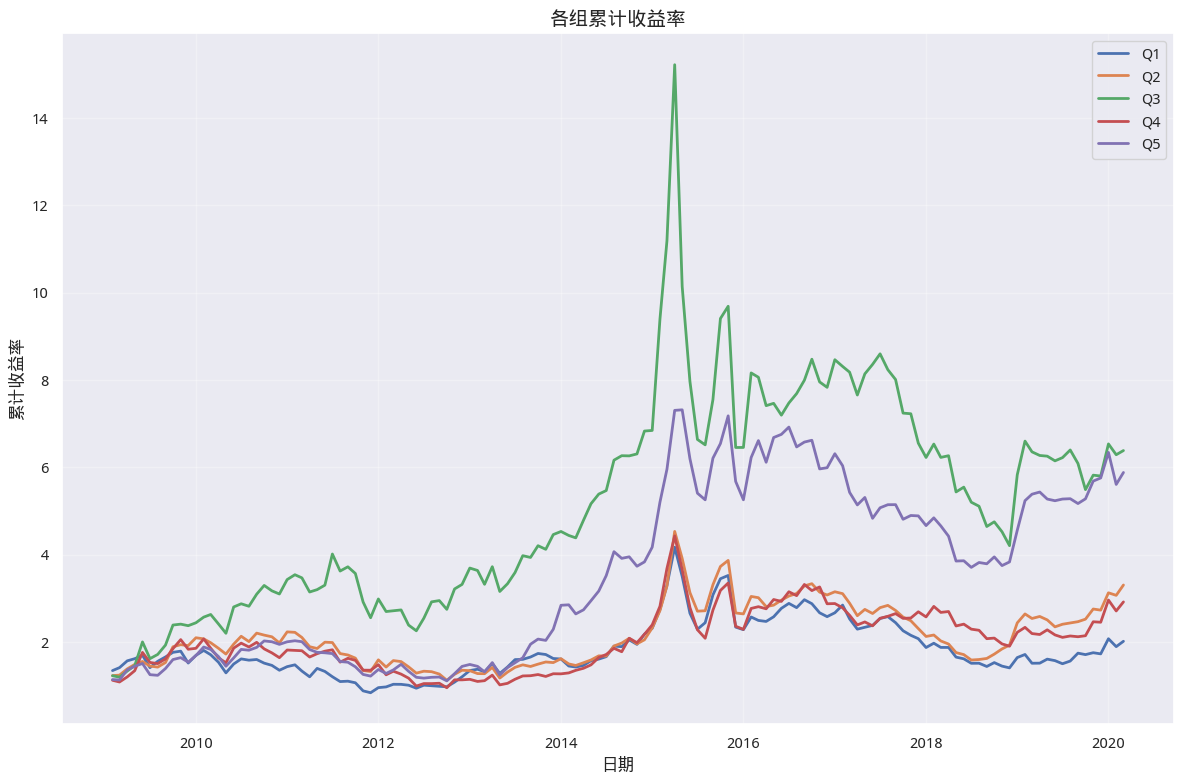

In [6]:
plot_cumulative_returns(returns)